<a href="https://www.kaggle.com/code/kevinsimorangkir21/sentiment-analysis-using-gru?scriptVersionId=210046226" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Sentiment Analysis Using GRU
Tugas Besar Deep Learning Kelompok 6
<br>Anggota :
- Husni Na'fa Mubarok
- Kevin 
- Mayada
- Dwi Sulistiani
- Dhita

## Import Library

In [1]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 6.3 MB/s eta 0:00:00


In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import re
import nltk
import tqdm
import unicodedata
import contractions
from nltk.tokenize import word_tokenize
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from keras.layers import Layer
from keras import backend as K
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.models import Model
from keras.layers import Input, Embedding, Bidirectional, Concatenate, Dense, Dropout, LSTM#, CuDNNGRU
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, f1_score, auc

## Import Data

In [3]:
df = pd.read_csv("/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")

In [4]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


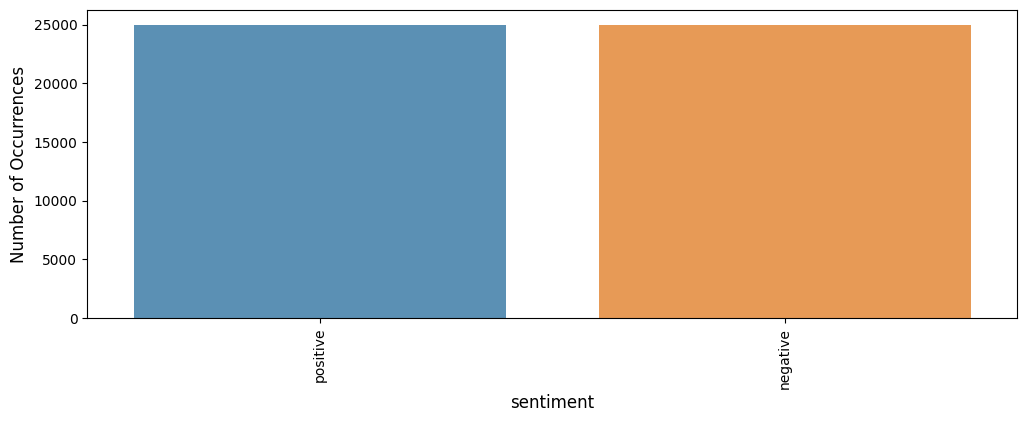

In [6]:
sentiment = df['sentiment'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(x=sentiment.index, y=sentiment.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('sentiment', fontsize=12)
plt.xticks(rotation=90)
plt.show();

## Data Preparation

### Data Cleaning

In [7]:
def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def stopwords_removal(words):
    list_stopwords = nltk.corpus.stopwords.words('english')
    return [word for word in words if word not in list_stopwords]

In [8]:
def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    #case folding
    doc = doc.lower()
    #remove special characters\whitespaces
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()
    #tokenize
    doc = word_tokenize(doc)
    #filtering
    doc = stopwords_removal(doc)
    norm_docs.append(doc)
  
  norm_docs = [" ".join(word) for word in norm_docs]
  return norm_docs

In [9]:
%%time
df.review = pre_process_corpus(df.review)

100%|██████████| 50000/50000 [01:25<00:00, 581.73it/s]


CPU times: user 1min 24s, sys: 2.21 s, total: 1min 26s
Wall time: 1min 26s


In [10]:
df.head()

,review,sentiment
0,one reviewers mentioned watching 1 oz episode ...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically family little boy jake thinks zombie...,negative
4,petter matteis love time money visually stunni...,positive


### Data Splitting

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df.review, df.sentiment, test_size=0.1, random_state=42)
X_train.shape , X_test.shape, y_train.shape, y_test.shape

((45000,), (5000,), (45000,), (5000,))

### Tokenizer

In [12]:
t = tf.keras.preprocessing.text.Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(X_test)
t.word_index['<PAD>'] = 0

### Sequence

In [13]:
train_sequences = t.texts_to_sequences(X_train)
test_sequences = t.texts_to_sequences(X_test)

In [14]:
VOCAB_SIZE = len(t.word_index)

print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=55194
Number of Documents=5000


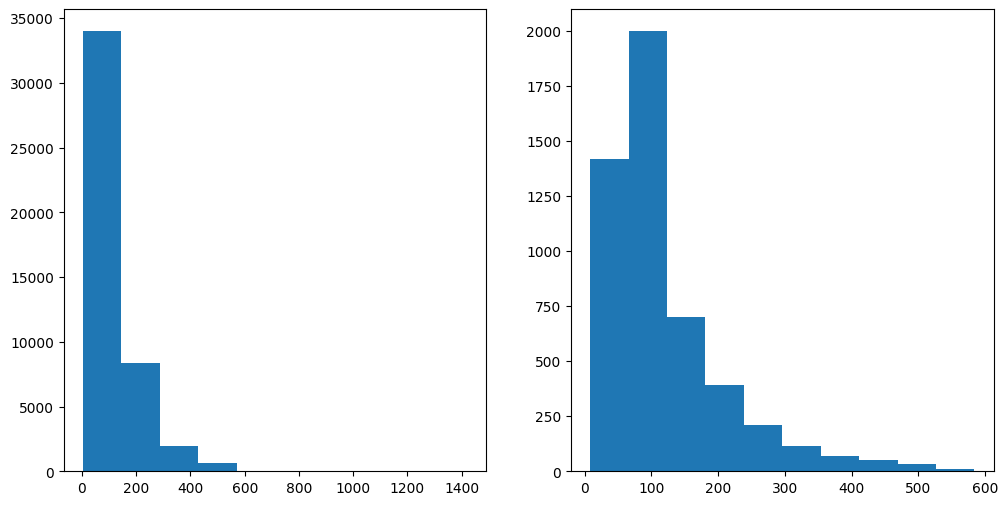

In [15]:
%matplotlib inline

train_lens = [len(s) for s in train_sequences]
test_lens = [len(s) for s in test_sequences]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

### Sequence Normalization

In [16]:
MAX_SEQUENCE_LENGTH = 100

# pad dataset to a maximum review length in words
X_train = tf.keras.utils.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = tf.keras.utils.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((45000, 100), (5000, 100))

### Encoding Labels

In [17]:
le = LabelEncoder()
num_classes=2

In [18]:
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

## Modelling Bidirectional GRU

In [19]:
EMBEDDING_DIM = 300 # dimension for dense embeddings for each token
GRU_DIM = 32 # total GRU units

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,))
embedded_sequences = Embedding(VOCAB_SIZE, EMBEDDING_DIM, trainable=True)(sequence_input)
#bigru = Bidirectional(layers.CuDNNGRU(GRU_DIM, return_sequences=True))(embedded_sequences)
bigru = keras.layers.Bidirectional(keras.layers.GRU(GRU_DIM, return_sequences=False, recurrent_dropout=0.2))(embedded_sequences)
#att = AttentionLayer(MAX_SEQUENCE_LENGTH)(bigru)
dense1 = Dense(GRU_DIM*2, activation='relu')(bigru)
dropout1 = Dropout(rate=0.3)(dense1)
dense2= Dense(GRU_DIM, activation='relu')(dropout1)
dropout2 = Dropout(rate=0.3)(dense2)

outp = keras.layers.Dense(1, activation='sigmoid')(dense2)
# initialize the model
model_bigru = keras.models.Model(inputs=sequence_input, outputs=outp)

    
model_bigru.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

In [20]:
model_bigru.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 100, 300)       │    16,558,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │        64,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,628,601 (63.43 MB)

 Trainable params: 16,628,601 (63.43 MB)

 Non-trainable params: 0 (0.00 B)

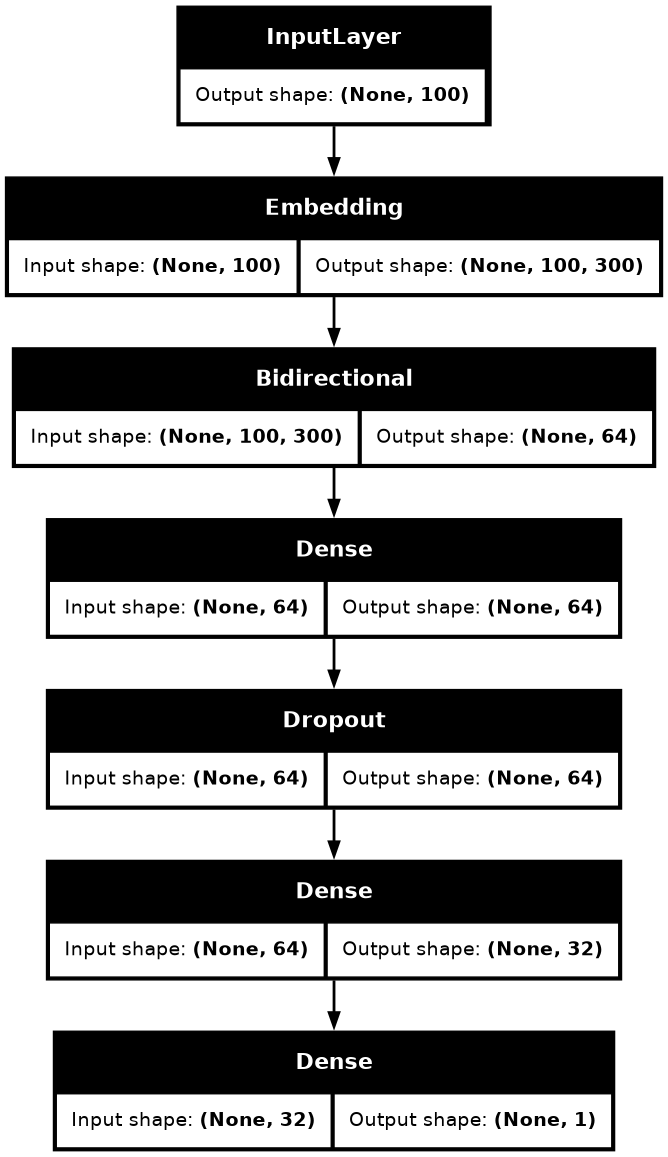

In [21]:
keras.utils.plot_model(model_bigru, show_shapes=True, dpi = 100)

### Train model

In [22]:
epochs = 100
batch_size = 128

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
mc = ModelCheckpoint('./best_model/best_model_bigru.keras', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
history = model_bigru.fit(X_train, y_train,  batch_size=batch_size, shuffle=True, validation_split=0.1, epochs=epochs, verbose=1, callbacks=[es, mc])

Epoch 1/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.6830 - loss: 1.8684
Epoch 1: val_loss improved from inf to 0.49005, saving model to ./best_model/best_model_bigru.keras
317/317 ━━━━━━━━━━━━━━━━━━━━ 96s 283ms/step - accuracy: 0.6832 - loss: 1.8668 - val_accuracy: 0.7624 - val_loss: 0.4901
Epoch 2/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.8679 - loss: 11.2405
Epoch 2: val_loss did not improve from 0.49005
317/317 ━━━━━━━━━━━━━━━━━━━━ 89s 281ms/step - accuracy: 0.8678 - loss: 11.2602 - val_accuracy: 0.7502 - val_loss: 0.5026
Epoch 3/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.9117 - loss: 0.2327
Epoch 3: val_loss did not improve from 0.49005
317/317 ━━━━━━━━━━━━━━━━━━━━ 88s 279ms/step - accuracy: 0.9117 - loss: 0.2327 - val_accuracy: 0.7442 - val_loss: 0.5481
Epoch 4/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.9453 - loss: 0.1571
Epoch 4: val_loss did not improve from 0.49005
317/317 ━━━━━━━━━━━━━━━━━━━━ 89s 279ms/st

### Evaluation

#### Model Accuracy

In [23]:
saved_model = load_model('./best_model/best_model_bigru.keras')
train_acc = saved_model.evaluate(X_train, y_train, verbose=1)
test_acc = saved_model.evaluate(X_test, y_test, verbose=1)
print('Train: %.2f%%, Test: %.2f%%' % (train_acc[1]*100, test_acc[1]*100))

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 72s 51ms/step - accuracy: 0.8366 - loss: 0.3995
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.7589 - loss: 0.4874
Train: 83.00%, Test: 75.88%


#### Identify Overfitting

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


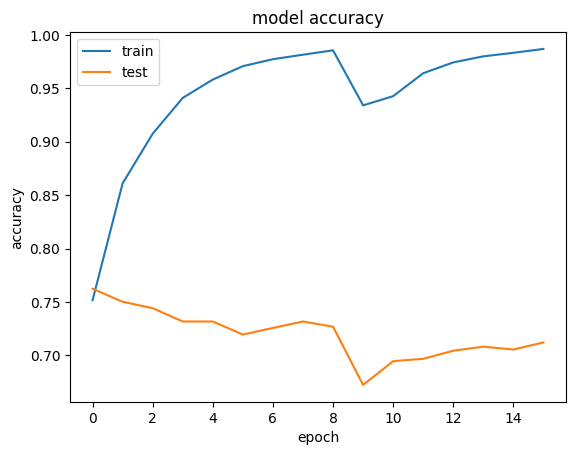

In [24]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('model akurasi dropout 0.5 balance.jpg')
plt.show()

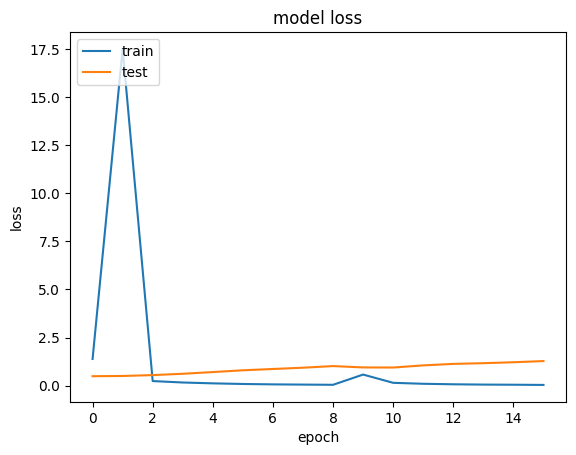

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('model loss dropout 0.5 balance.jpg')
plt.show()

In [26]:
prediction_probs = model_bigru.predict(X_test, verbose=1).ravel()
predictions = [1 if prob > 0.5 else 0 for prob in prediction_probs]

157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step


#### Confusion Matrix

In [27]:
labels = ['positive', 'negative']
print(classification_report(y_test, predictions))
pd.DataFrame(confusion_matrix(y_test, predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.68      0.80      0.74      2481
           1       0.76      0.63      0.69      2519

    accuracy                           0.71      5000
   macro avg       0.72      0.71      0.71      5000
weighted avg       0.72      0.71      0.71      5000



,positive,negative
positive,1993,488
negative,944,1575


#### ROC AUC

In [28]:
def plot_roc_curve(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], ls="--")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

model AUC score: 0.7925766592278369


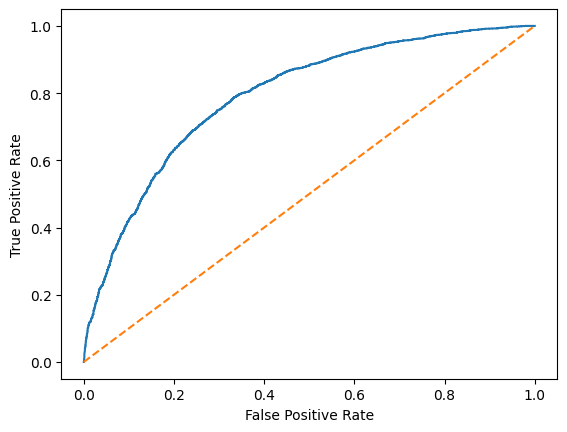

In [29]:
plot_roc_curve(y_test, prediction_probs)
print(f'model AUC score: {roc_auc_score(y_test, prediction_probs)}')

#### Precision-Recall

model f1 score: 0.6874727193365343 model AUC score: 0.7791539240186494


Text(0, 0.5, 'Precision')

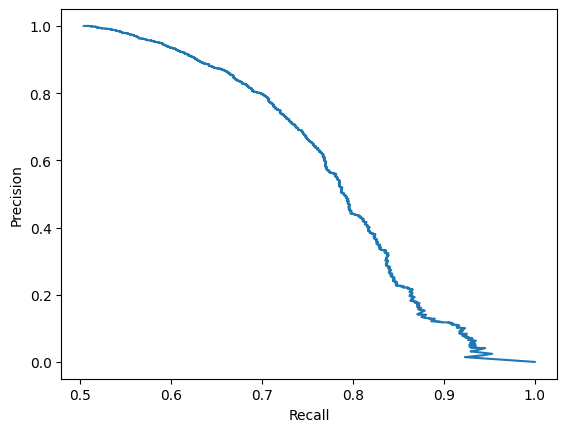

In [30]:
precision, recall, thresholds = precision_recall_curve(y_test, prediction_probs)
print(f'model f1 score: {f1_score(y_test, predictions)} model AUC score: {auc(recall, precision)}')
plt.plot(precision, recall)
plt.xlabel('Recall')
plt.ylabel('Precision')

## Modelling GRU Attention Bidirectional

### Attention Mechanism

In [31]:
from tensorflow import keras

class AttentionLayer(keras.layers.Layer):
  def __init__(self, step_dim,
                W_regularizer=None, b_regularizer=None,
                W_constraint=None, b_constraint=None,
                bias=True, **kwargs):
    super(AttentionLayer, self).__init__(**kwargs)
    self.supports_masking = True
    self.init = keras.initializers.get('glorot_uniform')
    self.W_regularizer = keras.regularizers.get(W_regularizer)
    self.b_regularizer = keras.regularizers.get(b_regularizer)
    self.W_constraint = keras.constraints.get(W_constraint)
    self.b_constraint = keras.constraints.get(b_constraint)
    self.bias = bias
    self.step_dim = step_dim
    self.features_dim = 0

  def build(self, input_shape):
    assert len(input_shape) == 3
    self.W = self.add_weight(shape=(input_shape[-1],),
                              initializer=self.init,
                              name='{}_W'.format(self.name),
                              regularizer=self.W_regularizer,
                              constraint=self.W_constraint)
    self.features_dim = input_shape[-1]
    if self.bias:
      self.b = self.add_weight(shape=(input_shape[1],),
                                initializer='zero',
                                name='{}_b'.format(self.name),
                                regularizer=self.b_regularizer,
                                constraint=self.b_constraint)
    else:
      self.b = None
    self.built = True

  def compute_mask(self, input, input_mask=None):
    return None  # Do not pass the mask to the next layers

  def call(self, x, mask=None):
    features_dim = self.features_dim
    step_dim = self.step_dim

    eij = keras.backend.dot(keras.backend.reshape(x, (-1, features_dim)),
                             keras.backend.reshape(self.W, (features_dim, 1)))
    eij = keras.backend.reshape(eij, (-1, step_dim))

    if self.bias:
      eij += self.b

    eij = keras.activations.tanh(eij)
    a = keras.backend.exp(eij)

    if mask is not None:
      a *= mask  # No need for casting to floatX in TensorFlow 2.x

    a /= keras.backend.sum(a, axis=1, keepdims=True) + keras.backend.epsilon()  # Consider removing epsilon if necessary
    a = keras.backend.expand_dims(a)
    weighted_input = x * a

    return keras.backend.sum(weighted_input, axis=1)

  def compute_output_shape(self, input_shape):
    return input_shape[0], self.features_dim

  def get_config(self):
        config = {'step_dim': self.step_dim}
        base_config = super(AttentionLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

### Model Architecture

In [32]:
EMBEDDING_DIM = 300 # dimension for dense embeddings for each token
GRU_DIM = 32 # total GRU units

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,))
embedded_sequences = Embedding(VOCAB_SIZE, EMBEDDING_DIM, trainable=True)(sequence_input)
#bigru = Bidirectional(layers.CuDNNGRU(GRU_DIM, return_sequences=True))(embedded_sequences)
bigru = keras.layers.Bidirectional(keras.layers.GRU(GRU_DIM, return_sequences=True, recurrent_dropout=0.2))(embedded_sequences)
att = AttentionLayer(MAX_SEQUENCE_LENGTH)(bigru)
dense1 = Dense(GRU_DIM*2, activation='relu')(att)
dropout1 = Dropout(rate=0.3)(dense1)
dense2= Dense(GRU_DIM, activation='relu')(dropout1)
dropout2 = Dropout(rate=0.3)(dense2)

outp = keras.layers.Dense(1, activation='sigmoid')(dense2)
# initialize the model
model_attbigru = keras.models.Model(inputs=sequence_input, outputs=outp)

    
model_attbigru.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

In [33]:
model_attbigru.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 100, 300)       │    16,558,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 100, 64)        │        64,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer                 │ (None, 64)             │           164 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,628,765 (63.43 MB)

 Trainable params: 16,628,765 (63.43 MB)

 Non-trainable params: 0 (0.00 B)

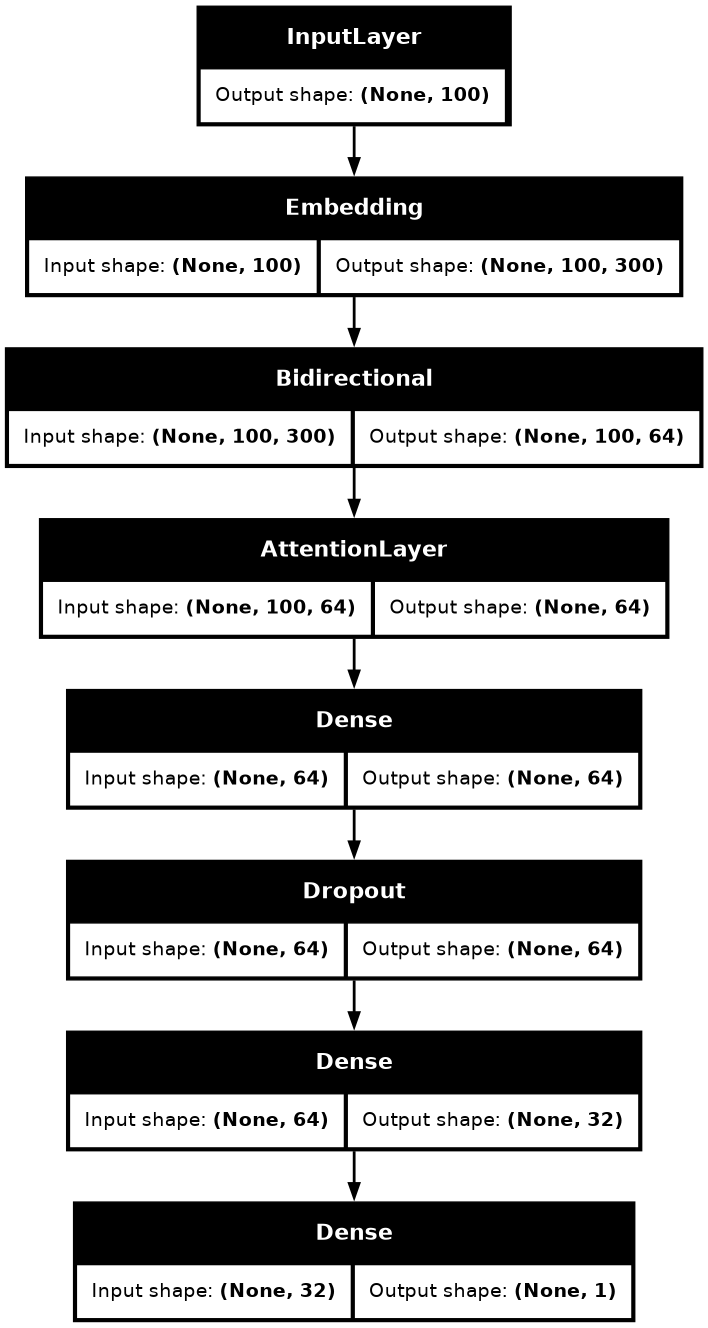

In [34]:
keras.utils.plot_model(model_attbigru, show_shapes=True, dpi = 100)

### Train model

In [35]:
epochs = 100
batch_size = 128

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
mc = ModelCheckpoint('./best_model/best_model_attbigru.keras', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
history = model_attbigru.fit(X_train, y_train,  batch_size=batch_size, shuffle=True, validation_split=0.1, epochs=epochs, verbose=1, callbacks=[es, mc])

Epoch 1/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.7499 - loss: 0.8760
Epoch 1: val_loss improved from inf to 0.28587, saving model to ./best_model/best_model_attbigru.keras
317/317 ━━━━━━━━━━━━━━━━━━━━ 91s 276ms/step - accuracy: 0.7501 - loss: 0.8753 - val_accuracy: 0.8911 - val_loss: 0.2859
Epoch 2/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.9367 - loss: 0.1800
Epoch 2: val_loss improved from 0.28587 to 0.28379, saving model to ./best_model/best_model_attbigru.keras
317/317 ━━━━━━━━━━━━━━━━━━━━ 88s 277ms/step - accuracy: 0.9367 - loss: 0.1800 - val_accuracy: 0.8820 - val_loss: 0.2838
Epoch 3/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.9662 - loss: 0.1026
Epoch 3: val_loss did not improve from 0.28379
317/317 ━━━━━━━━━━━━━━━━━━━━ 87s 273ms/step - accuracy: 0.9661 - loss: 0.1026 - val_accuracy: 0.8687 - val_loss: 0.3229
Epoch 4/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.9800 - loss: 0.3947
Epoch 4: val_loss did not i

### Evaluation

#### Model Accuracy

In [36]:
saved_model = load_model('./best_model/best_model_attbigru.keras', custom_objects={'AttentionLayer': AttentionLayer})
train_acc = saved_model.evaluate(X_train, y_train, verbose=1)
test_acc = saved_model.evaluate(X_test, y_test, verbose=1)
print('Train: %.2f%%, Test: %.2f%%' % (train_acc[1]*100, test_acc[1]*100))

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 73s 51ms/step - accuracy: 0.9688 - loss: 0.1318
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.8857 - loss: 0.2670
Train: 96.00%, Test: 88.52%


#### Identify Overfitting

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


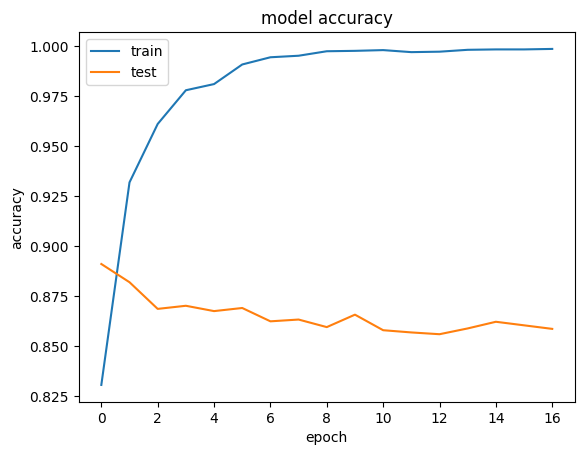

In [37]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('model akurasi dropout 0.5 balance.jpg')
plt.show()

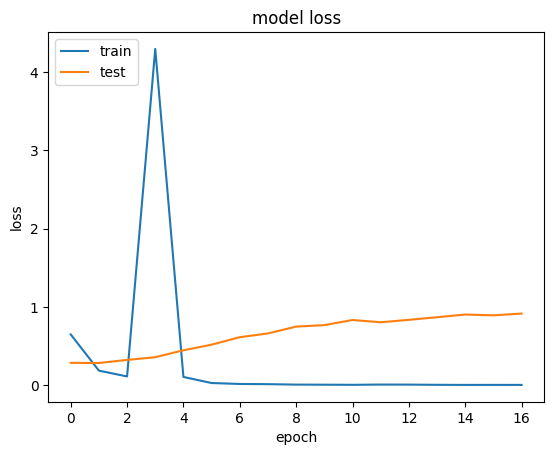

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('model loss dropout 0.5 balance.jpg')
plt.show()

In [39]:
prediction_probs = model_attbigru.predict(X_test, verbose=1).ravel()
predictions = [1 if prob > 0.5 else 0 for prob in prediction_probs]

157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step


#### Confusion Matrix

In [40]:
labels = ['positive', 'negative']
print(classification_report(y_test, predictions))
pd.DataFrame(confusion_matrix(y_test, predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.88      0.82      0.85      2481
           1       0.84      0.89      0.86      2519

    accuracy                           0.86      5000
   macro avg       0.86      0.85      0.85      5000
weighted avg       0.86      0.86      0.86      5000



,positive,negative
positive,2044,437
negative,287,2232


#### ROC AUC

In [41]:
def plot_roc_curve(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], ls="--")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

model AUC score: 0.9343738094312328


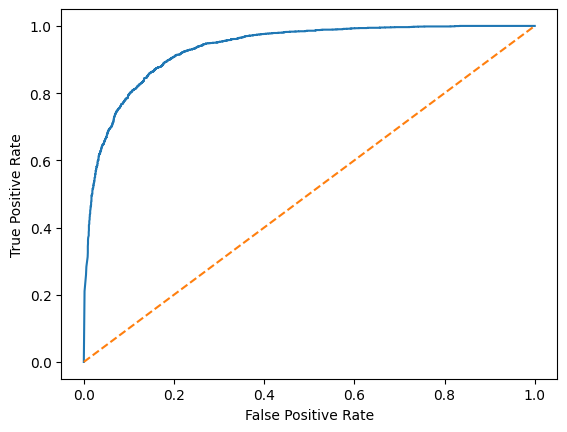

In [42]:
plot_roc_curve(y_test, prediction_probs)
print(f'model AUC score: {roc_auc_score(y_test, prediction_probs)}')

#### Precision-Recall

model f1 score: 0.8604471858134156 model AUC score: 0.9333678444730901


Text(0, 0.5, 'Precision')

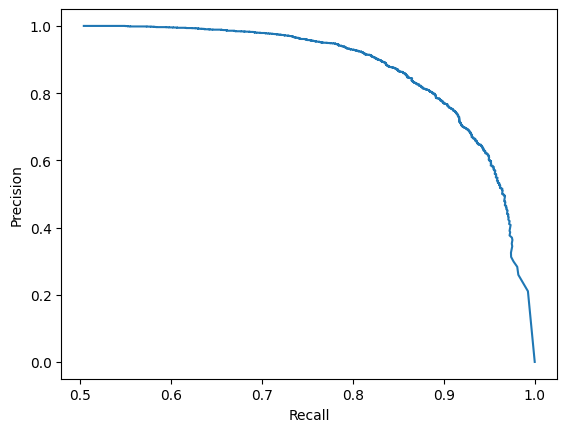

In [43]:
precision, recall, thresholds = precision_recall_curve(y_test, prediction_probs)
print(f'model f1 score: {f1_score(y_test, predictions)} model AUC score: {auc(recall, precision)}')
plt.plot(precision, recall)
plt.xlabel('Recall')
plt.ylabel('Precision')

## Hasil dan Kesimpulan